In [1]:
import os
import sys

from pathlib import Path

# si aggiunge al path la cartella utils per avere visibilità del modulo
module_path = Path(os.getcwd()).parent.parent
module_path = os.path.join(module_path, "project-detective")

sys.path.append(module_path)

In [2]:
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import utils.semi_hard_mining as shm

from torch import nn
from tqdm import tqdm
from skimage import io
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

c:\Users\acali\anaconda3\envs\pdetective\project-detective\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# serve per ricaricare automaticamente il codice modificato
%load_ext autoreload
%autoreload 2

In [4]:
# directory da dove vengono prelevate le immagini
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "latent_diffusion")

# per far funzionare il modello su immagini rgb o in scala di grigi (per usare fourier)
mode="rgb"

BATCH_SIZE = 32

LR = 0.001

EPOCHS = 30

DEVICE = "cuda"

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"Available devices: {torch.cuda.device_count()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.2.2+cu121
CUDA version: 12.1
cuDNN version: 8801
Available devices: 1
Device name: NVIDIA GeForce RTX 2050


In [5]:
csv_path = os.path.join("..", "datasets", "semi_hard_latent_diffusion_database.csv")
df = pd.read_csv(csv_path)

df = df.sample(frac=1)

df.head()

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

print(f"train dataset size: {len(train_df)}")
print(f"val dataset size: {len(valid_df)}")

train dataset size: 4449
val dataset size: 1113


In [6]:
# carica le immagini nel dataset
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    
    if mode == "rgb":
      # le immagini Anchor sono memorizzate in due dataset diversi
      if "latent" in row.Anchor:
        A_img = io.imread(os.path.join(fake_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(fake_data_dir, row.Positive))
        N_img = io.imread(os.path.join(real_data_dir, row.Negative))
      else:
        A_img = io.imread(os.path.join(real_data_dir, row.Anchor))
        P_img = io.imread(os.path.join(real_data_dir, row.Positive))
        N_img = io.imread(os.path.join(fake_data_dir, row.Negative))
          
      # normalizzazione per immagini in rgb 
      A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    if mode == "grey_scale":
      A_img = np.expand_dims(A_img, 0)
      P_img = np.expand_dims(P_img, 0)
      N_img = np.expand_dims(N_img, 0)
      
      A_img = torch.from_numpy(A_img) / 255.0
      P_img = torch.from_numpy(P_img) / 255.0
      N_img = torch.from_numpy(N_img) / 255.0

    # A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    # P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    # N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [7]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"trainset size: {len(trainset)}")
print(f"validset size: {len(validset)}")

trainset size: 4449
validset size: 1113


In [8]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [9]:
print(f"#batches in trainloader : {len(trainloader)}")
print(f"#batches in validloader : {len(validloader)}")

#batches in trainloader : 140
#batches in validloader : 35


In [10]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model_Pretrained(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model_Pretrained, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [11]:
# funzione per caricare il modello di rete neurale direttamente dalle repository online
class APN_Model(nn.Module):

  # size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    # caricamento del modello, in questo caso efficientnet b0 (architettura più leggera della famiglia)
    self.efficientnet = timm.create_model("tf_efficientnetv2_b0", pretrained=False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [12]:
model = APN_Model_Pretrained()

# per processare le immagini in scala di grigi per fare fourier serve una CNN 2D
if mode == "grey_scale":
    model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

APN_Model_Pretrained(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2dSame(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (bn1): BatchNormAct2d(
            64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [13]:
# funzione di train
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  # on dropout 
  total_loss = 0.0

  for A, P, N in tqdm(dataloader, desc="model training..."):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    # qui vengono creati gli embeddings, le cui distanze verranno calcolate dopo
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    # criterion è la funzione di loss triplet
    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [14]:
# funzione di evaluation
def eval_fn(model, dataloader, criterion):
  model.eval() 
  # off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader, desc="model validating..."):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

  return total_loss / len(dataloader)

In [15]:
# triplet loss e adam
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [16]:
# training
best_valid_loss = np.Inf

training_epoch_loss = []
validation_epoch_loss = []


for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  training_epoch_loss.append(train_loss)
  validation_epoch_loss.append(valid_loss)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("successful weights saving...")

  print(f"epochs: {i+1}, train_loss: {train_loss}, valid_loss: {valid_loss}")

model validating...: 100%|██████████| 35/35 [00:19<00:00,  1.79it/s]


successful weights saving...
epochs: 1, train_loss: 0.6446919884000506, valid_loss: 0.7547458912645068


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


successful weights saving...
epochs: 2, train_loss: 0.4038567936846188, valid_loss: 0.48536600470542907


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


successful weights saving...
epochs: 3, train_loss: 0.33604004308581353, valid_loss: 0.46054823228291103


model validating...: 100%|██████████| 35/35 [00:18<00:00,  1.89it/s]


successful weights saving...
epochs: 4, train_loss: 0.26878230103424616, valid_loss: 0.3933376469782421


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


epochs: 5, train_loss: 0.2677328622234719, valid_loss: 0.46557412573269435


model validating...: 100%|██████████| 35/35 [00:19<00:00,  1.81it/s]


epochs: 6, train_loss: 0.2838183296312179, valid_loss: 0.5514495462179184


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


epochs: 7, train_loss: 0.15080685610217706, valid_loss: 0.49217374324798585


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


epochs: 8, train_loss: 0.11805930478232247, valid_loss: 0.4559659702437265


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]


epochs: 9, train_loss: 0.139039157597082, valid_loss: 0.4506947851606778


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


epochs: 10, train_loss: 0.2832341517720904, valid_loss: 0.41067932418414527


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


epochs: 11, train_loss: 0.11858129331043789, valid_loss: 0.5353695963110242


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


epochs: 12, train_loss: 0.13049348518252374, valid_loss: 0.49974339178630284


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


epochs: 13, train_loss: 0.12108942328819207, valid_loss: 0.44977798142603465


model validating...: 100%|██████████| 35/35 [00:17<00:00,  2.00it/s]


epochs: 14, train_loss: 0.13455705126481396, valid_loss: 0.7903035572596959


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


epochs: 15, train_loss: 0.20479411690362861, valid_loss: 0.4802767221416746


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


epochs: 16, train_loss: 0.15893732429082905, valid_loss: 0.5409670257142611


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


epochs: 17, train_loss: 0.15908083096146583, valid_loss: 0.4406215301581791


model validating...: 100%|██████████| 35/35 [00:17<00:00,  2.00it/s]


epochs: 18, train_loss: 0.15038900508412292, valid_loss: 0.4657800242304802


model validating...: 100%|██████████| 35/35 [00:17<00:00,  2.00it/s]


epochs: 19, train_loss: 0.1420150854757854, valid_loss: 0.5433899913515363


model validating...: 100%|██████████| 35/35 [00:18<00:00,  1.87it/s]


epochs: 20, train_loss: 0.1702677301530327, valid_loss: 0.5121296920946666


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


epochs: 21, train_loss: 0.1765882604356323, valid_loss: 0.4450066803821496


model validating...: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]


epochs: 22, train_loss: 0.09658059464501483, valid_loss: 0.5710828921624592


model validating...: 100%|██████████| 35/35 [00:18<00:00,  1.89it/s]


epochs: 23, train_loss: 0.13923445280109134, valid_loss: 0.7014810732432775


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


epochs: 24, train_loss: 0.09287144267665488, valid_loss: 0.6138370871543884


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


epochs: 25, train_loss: 0.07608782585178103, valid_loss: 0.4407199225255421


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


successful weights saving...
epochs: 26, train_loss: 0.12896497917494604, valid_loss: 0.33977772699935094


model validating...: 100%|██████████| 35/35 [00:18<00:00,  1.89it/s]


epochs: 27, train_loss: 0.07531529417527573, valid_loss: 0.3737212095941816


model validating...: 100%|██████████| 35/35 [00:18<00:00,  1.92it/s]


epochs: 28, train_loss: 0.16100183932908943, valid_loss: 0.5880771023886544


model validating...: 100%|██████████| 35/35 [00:18<00:00,  1.86it/s]


epochs: 29, train_loss: 0.110157296700137, valid_loss: 0.5413281785590308


model validating...: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]

epochs: 30, train_loss: 0.08305708012942757, valid_loss: 0.47411277166434695


<function matplotlib.pyplot.show(close=None, block=None)>

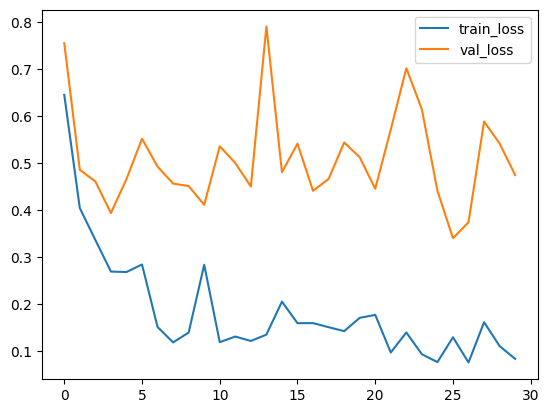

In [17]:
# plot della training e validation loss
plt.plot(training_epoch_loss, label="train_loss")
plt.plot(validation_epoch_loss, label="val_loss")
plt.legend()

plt.show

In [20]:
# funzione per generare i vettori di encoding
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if mode == "rgb":
        # serve per trovare correttamente l'immagine
        if "latent" in i:
          dirFolder = fake_data_dir
          A = io.imread(os.path.join(dirFolder,i))
        else: 
          dirFolder = real_data_dir
          A = io.imread(os.path.join(dirFolder,i))

        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      
      if mode == "grey_scale":
        A = io.imread(os.path.join(dirFolder,i))

        A = np.expand_dims(A, 0)
        A = torch.from_numpy(A.astype(np.int32)) / 255.0
        
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [21]:
# per ricaricare il modello una volta allenato
model.load_state_dict(torch.load("best_model.pt"))

# si creano gli embeddings che vengono memorizzati per non rifarlo ad ogni allenamento
df_enc = get_encoding_csv(model, df["Anchor"], real_data_dir)

df_enc.to_csv("database.csv", index=False)

100%|██████████| 5562/5562 [01:14<00:00, 74.66it/s]


In [22]:
df_enc = pd.read_csv('database.csv')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,latentdiff-t2i/images/img001235.jpg,-0.379540,-0.693550,-1.026947,0.081677,0.994285,-0.086808,0.853181,-0.279657,0.680549,...,0.352137,-0.395448,-0.462917,0.230836,0.747140,0.215153,0.267420,-0.498224,-0.025333,-0.913312
1,latentdiff/504/img004518.jpg,-0.461260,-0.777598,-1.099412,0.035145,1.061891,-0.054096,0.305907,-0.284068,0.804209,...,0.463494,-0.349090,-0.597726,0.212629,0.757924,0.246477,0.252766,-0.405188,0.005393,-1.028158
2,coco/coco2017/test2017/img000281.jpg,-0.413617,-0.877737,-1.045015,0.091601,1.033040,0.058103,0.161028,-0.189131,0.774492,...,0.350987,-0.292115,-0.580639,0.302378,0.678987,0.150034,0.326671,-0.504156,-0.012063,-0.914634
3,coco/coco2017/test2017/img004832.jpg,-0.313060,-0.602164,-0.997461,0.089503,0.972056,-0.091893,0.631071,-0.299914,0.662176,...,0.253007,-0.416795,-0.405265,0.173236,0.791444,0.272352,0.252767,-0.550135,-0.045932,-0.816266
4,coco/coco2017/train2017/img093626.jpg,-0.447335,-0.848469,-1.189584,0.060203,1.151604,-0.044917,0.390221,-0.389952,0.840058,...,0.325941,-0.452547,-0.522280,0.184210,0.811040,0.234204,0.260926,-0.576868,-0.056554,-1.057172


In [23]:
# approssimazione della distanza, senza la radice quadrata, per fare i primi allenamenti velocemente
def euclidean_dist(img_enc, anc_enc_arr):
    # dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    dist = np.sqrt(dist)
    return dist

In [32]:
path = os.path.join(Path(os.getcwd()).parent, "datasets", "testList_latent_diffusion.csv")
df = pd.read_csv(path)

print(df["real"])
print(df.size)
df.head()

0       coco/coco2017/train2017/img101997.jpg
1       coco/coco2017/train2017/img095328.jpg
2        coco/coco2017/test2017/img035961.jpg
3        coco/coco2017/test2017/img028105.jpg
4       coco/coco2017/train2017/img041463.jpg
                        ...                  
1107    coco/coco2017/train2017/img150874.jpg
1108    coco/coco2017/train2017/img062367.jpg
1109    coco/coco2017/train2017/img128702.jpg
1110    coco/coco2017/train2017/img149868.jpg
1111    coco/coco2017/train2017/img092618.jpg
Name: real, Length: 1112, dtype: object
2224


,real,fake
0,coco/coco2017/train2017/img101997.jpg,latentdiff-t2i/images/img009911.jpg
1,coco/coco2017/train2017/img095328.jpg,latentdiff-t2i/images/img003788.jpg
2,coco/coco2017/test2017/img035961.jpg,latentdiff-t2i/images/img000134.jpg
3,coco/coco2017/test2017/img028105.jpg,latentdiff-t2i/images/img006341.jpg
4,coco/coco2017/train2017/img041463.jpg,latentdiff/527/img004769.jpg


In [33]:
def getImageEmbeddings(img, model):
    if mode == "rgb":
        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
      
    if mode == "grey_scale":
        img = np.expand_dims(img, 0)
        img = torch.from_numpy(img) / 255
    
    model.eval()
    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [34]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database["Anchor"]

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database["Anchor"][closest_idx[0]]

In [48]:
# DataTestReal = 'C:/Users/polsi/Desktop/Lavori/DeepFake/Datasets/Artifact/cycle_gan/st/test/'
path = Path(os.getcwd()).parent.parent
real_data_dir = os.path.join(path, "artifact", "coco")
fake_data_dir = os.path.join(path, "artifact", "latent_diffusion")

y_true = []
y_pred = []

tempDf = df
tempDf.head()
tempDf.shape

(1112, 2)

In [51]:
# testo i fake
currentTest = "fake"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on fake images..."):
    path = os.path.join(fake_data_dir, row[currentTest])
    img_name = path
    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)
    
    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if str(closestLabel).startswith("latent"):
            y_pred.append("fake")
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

testing on fake images...: 1112it [01:26, 12.81it/s]


In [52]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
1112
['real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 

In [53]:
# testo i real
currentTest = "real"
database = df_enc

# prendo i primi 500 Fake
for index, row in tqdm(tempDf.iterrows(), desc="testing on real images..."):
    path = os.path.join(real_data_dir, row[currentTest])
    img_name = path

    img = io.imread(img_name)

    img_enc = getImageEmbeddings(img, model)

    closestLabel = searchInDatabase(img_enc, database)
    
    if mode == "rgb":
        if "latent" in closestLabel:
            y_pred.append("fake")
            
        else:
            y_pred.append("real")

    if mode == "grey_scale": 
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


testing on real images...: 1112it [01:28, 12.53it/s]


In [54]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

0
2224
['real', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 

In [55]:
# creo i vettori di ground truth
y_true = np.array(["fake"] * 1112)
print(y_true.shape)

temp = np.array(["real"] * 1112)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

# calcolo la matrice di confusione (quella di scikit-learn dispone i risultati come nella cella di sotto)
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
print(cm)

(1112,)
(1112,)
(2224,)
[[572 540]
 [575 537]]


In [56]:
TN, FP, FN, TP = cm.ravel()

# metriche
accuracy = round((TP + TN) / (TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
f1_score = round((2 * precision * recall) / (precision + recall), 4)

print({"Accuracy":accuracy, "Precision":precision, "Recall":recall, "Specificity":specificity, "F1 Score":f1_score})

{'Accuracy': 49.87, 'Precision': 49.86, 'Recall': 48.29, 'Specificity': 51.4388, 'F1 Score': 49.0624}


In [57]:
# si salvano i risultati in un file .csv
df_results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "Specificity", "F1 Score"])
df_results.loc[0] = [accuracy, precision, recall, specificity, f1_score]

# si differenziano i risultati in base al tipo di immagini e dataset usati
dataset = fake_data_dir.split("\\")[-1]
path = os.path.join("..", "results", "siamese_" + mode + "_" + dataset + "_results.csv")

df_results.to_csv(path, index=False)